<a href="https://colab.research.google.com/github/NicholasBaraghini/Ball-and-Beam-system-Optimal-Control/blob/main/OPTCON_Grp21_Ball_and_Beam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTIMAL CONTROL EXAM PROJECT**

 Group 21:
   - Baraghini Nicholas 0000984041 
   - Curto Fabio
   - Iadarola Federico

In [1]:
# local file path
lfp = 'C:/Users/Baraghini/PycharmProjects/Ball-and-Beam-system-Optimal-Control'
# Libraries
import numpy as np
import matplotlib
import sys
sys.path.insert(1, lfp+'/Project Modules')
import system_dynamic as sd
import optcon as opt
import cost_function
import matplotlib.pyplot as plt_
import visualization as visu
%matplotlib widget

**TRAJECTORY EXPLORATION** (Task 1)

In [2]:
# PARAMETERS SETTING

max_iterations = 20;
STOP_ITER = 5E-6; #Stop Iteration descent threshold

#step_size = 0.1;
cc = 0.05
beta = 0.5

nx = 4  # number of states
nu = 1  # number of inputs
tf = 15 # Seconds

params = {'tf': tf, # Seconds
          'dt':0.01,   # Step size - Forward Euler method
          'gg':9.81,    # gravitational acceleration [m/s^2]
          'mm': 6.4352E-5,    # ball mass [kg]
          'rr':0.0127,   # ball radius [m]
          'ii': 3.2691E-8, # ball inertia [kg*m^2]
          'II':0.0083,  # beam inertia [kg*m^2]
          'LL':1,        # beam length [m]
          'dim_X': nx,
          'dim_U':nu,
          'QQ':np.array([[1500, 0, 0 , 0],
                        [ 0 ,1, 0 , 0],
                        [ 0 , 0,100, 0],
                        [ 0 , 0, 0 ,1]]),
          'RR':1,
          'QQ_T':np.array([[1000, 0, 0 , 0],
                          [ 0 ,1000, 0 , 0],
                          [ 0 , 0,100, 0],
                          [ 0 , 0, 0 ,10]])
              }

TT = int(tf/params['dt']); # rounding down of the time span divided in time in number oof time intervals

**Reference Definition** \
Step reference change between two equilibria 

In [3]:
# REFERENCE DEFINITION
init_pos = 0*0.5*params['LL'] # ball initial position on the beam [m]
ref_pos1 = -0.8*0.5*params['LL'] # ball reference position 1 on the beam [m]
ref_pos2 =  0.8*0.5*params['LL'] # ball reference position 2 on the beam [m]
ref_pos3 = 0*0.5*params['LL'] # ball reference position 3 on the beam [m]

init_inp = params['mm']*params['gg']*init_pos # input reference torque at init position
ref_inp1 = params['mm']*params['gg']*ref_pos1; # input reference torque at reference pos ref_pos1
ref_inp2 = params['mm']*params['gg']*ref_pos2; # input reference torque at reference pos ref_pos2
ref_inp3 = params['mm']*params['gg']*ref_pos3; # input reference torque at reference pos ref_pos3


# state reference definition:
xx_ref = np.zeros((nx,TT))
xx_ref[0,0:round(TT/4)] = init_pos
xx_ref[0,round(TT/4):round(TT/2)] = ref_pos1
xx_ref[0,round(TT/2):round(3*TT/4)] = ref_pos2
xx_ref[0,round(3*TT/4):TT] = ref_pos3

# input reference definition
uu_ref = np.zeros((nu,TT))
uu_ref[0,0:round(TT/4)] = init_inp
uu_ref[0,round(TT/4):round(TT/2)] = ref_inp1
uu_ref[0,round(TT/2):round(3*TT/4)] = ref_inp2
uu_ref[0,round(3*TT/4):TT] = ref_inp3


xx_init = np.zeros((nx,1))
xx_init[0] = init_pos # initial state

**OPTIMIZATION LOOP**

In [4]:
## ITERATION LOOP

# Initializations
xx = np.zeros((nx,TT,max_iterations)) # state tensor
xx[0,0,:] = init_pos # init ball position
uu = np.zeros((nu,TT,max_iterations)) # input tensor
uu[0,0,:] = init_inp  # init torque input

cost = np.zeros((max_iterations,1)) # cost function values memory

descent = np.zeros((max_iterations,1)) # descent vector

#initialize trajectory
kk = 0
for tt in range(0,TT-1):

    uu_tk = uu[:, tt:tt + 1, kk:kk + 1] # shape (1,1,1)
    uu_ref_tt = uu_ref[:, tt:tt + 1] # shape (1,1)
    xx_tk = xx[:, tt:tt + 1, kk:kk + 1] # shape (4,1,1)
    xx_ref_tt = xx_ref[:, tt:tt + 1] # shape (4,1)

    cost_temp = cost_function.Stage_Cost(xx_tk, uu_tk, xx_ref_tt, uu_ref_tt, params)['cost_t']
    cost[kk] = cost[kk] + cost_temp[0]

xx_Tk = xx[:,TT-1:TT,kk:kk+1]
xx_ref_TT = xx_ref[:,TT-1:TT]
cost_temp = cost_function.Terminal_Cost(xx_Tk, xx_ref_TT,params)['cost_T']

cost[kk] = cost[kk] + cost_temp[0]
print('Initial cost : ', cost[kk])

# LOOP
for kk in range(0,max_iterations-1):

    KK = np.zeros((nu,nx,TT))
    SS = np.zeros((nu,TT)) #Sigma
    pp = np.zeros((nx,TT))
    PP = np.zeros((nx,nx,TT))
    dd = 0
    # Computation of the K, p, P, Sigma, and descent
    KK,SS,PP,pp,dd = opt.DDP_comp_t_k(kk, xx, uu, xx_ref, uu_ref, TT, params).values()
    gammas = opt.Armijo(kk, xx, uu, xx_init, init_inp, xx_ref, uu_ref, TT, cost, descent[kk], cc, beta, SS, KK, pp, params)
    xx,uu,cost = opt.Trajectory_Update(kk, xx, uu, xx_ref, uu_ref, xx_init, init_inp, TT, cost, gammas[-1], SS, KK, pp, params).values()

    dd = np.reshape(dd, 1)

    print('iteration:', kk )
    print('cost', cost[kk])
    print('descent', dd)

    if np.abs(dd)<STOP_ITER: #STOP CRITERION
       Max_Iter = kk
       descent[kk] = dd
       print("GJ WP")
       break
    descent[kk] = dd
    Max_Iter = kk


Initial cost :  [180000.00004782]
DDP_comp FINISHED
ARMIJO found
iteration: 0
cost [180000.00004782]
descent [-45220.86081928]
DDP_comp FINISHED
ARMIJO found
iteration: 1
cost [17712.50189843]
descent [-26.52813781]
DDP_comp FINISHED
ARMIJO found
iteration: 2
cost [17554.11919532]
descent [-0.42521371]
DDP_comp FINISHED
ARMIJO found
iteration: 3
cost [17551.92898418]
descent [-0.00022208]
DDP_comp FINISHED
ARMIJO found
iteration: 4
cost [17551.92765216]
descent [-1.16824417e-09]
GJ WP


**PLOTTING**

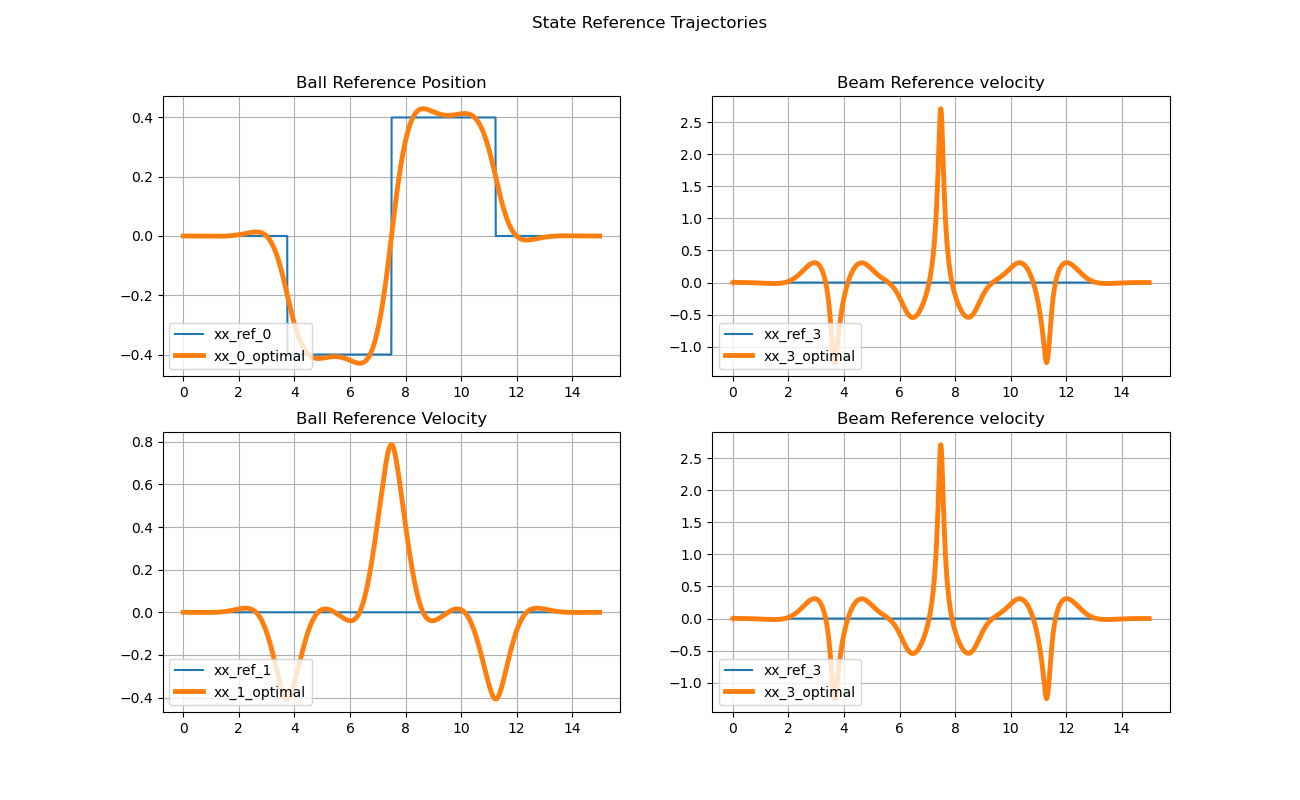

In [5]:
t = np.arange(0,params['tf'],params['dt'])
fig, axs = plt_.subplots(2, 2, figsize=(13,8))
fig.suptitle('State Reference Trajectories')
#pos
axs[0,0].plot(t, xx_ref[0, :], '-', label='xx_ref_0')
axs[0,0].plot(t, xx[0, :,Max_Iter], '-', label='xx_0_optimal',lw = 3.5)
axs[0,0].legend(loc='lower left', ncol=1)
axs[0, 0].set_title("Ball Reference Position")
#vel
axs[1,0].plot(t, xx_ref[1, :], '-', label='xx_ref_1')
axs[1,0].plot(t, xx[1, :,Max_Iter], '-', label='xx_1_optimal',lw = 3.5)
axs[1,0].legend(loc='lower left', ncol=1)
axs[1, 0].sharex(axs[0, 0])
axs[1, 0].set_title("Ball Reference Velocity")
#beam pos
axs[0,1].plot(t, xx_ref[3, :], '-', label='xx_ref_3')
axs[0,1].plot(t, xx[3, :,Max_Iter], '-', label='xx_3_optimal',lw = 3.5)
axs[0,1].legend(loc='lower left', ncol=1)
axs[0,1].set_title("Beam Reference velocity")
#beam vel
axs[1,1].plot(t, xx_ref[3, :], '-', label='xx_ref_3')
axs[1,1].plot(t, xx[3, :,Max_Iter], '-', label='xx_3_optimal',lw = 3.5)
axs[1,1].legend(loc='lower left', ncol=1)
axs[1,1].set_title("Beam Reference velocity")
axs[1,1].sharex(axs[0,1])
axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()
plt_.show()
plt_.close(fig)
fig.savefig(lfp+'/plot/task_1_2_state_reference.jpg', transparent = True)

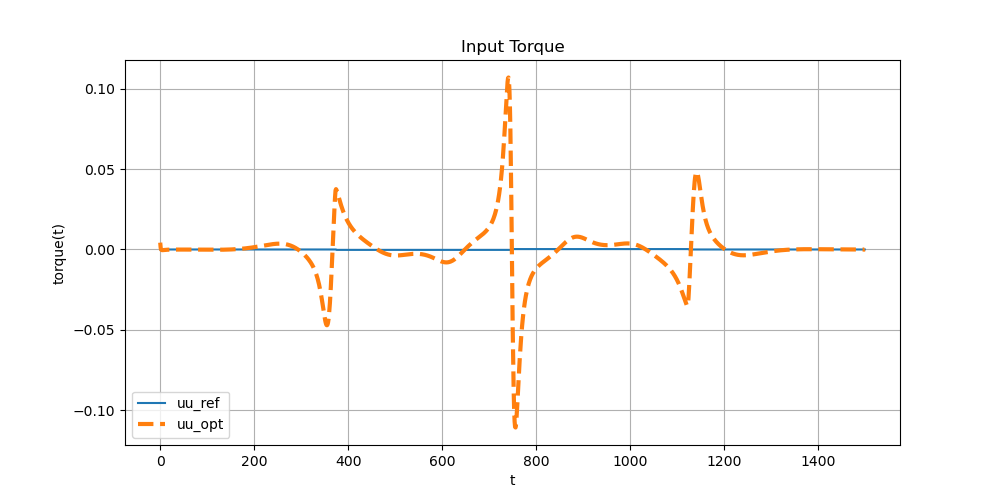

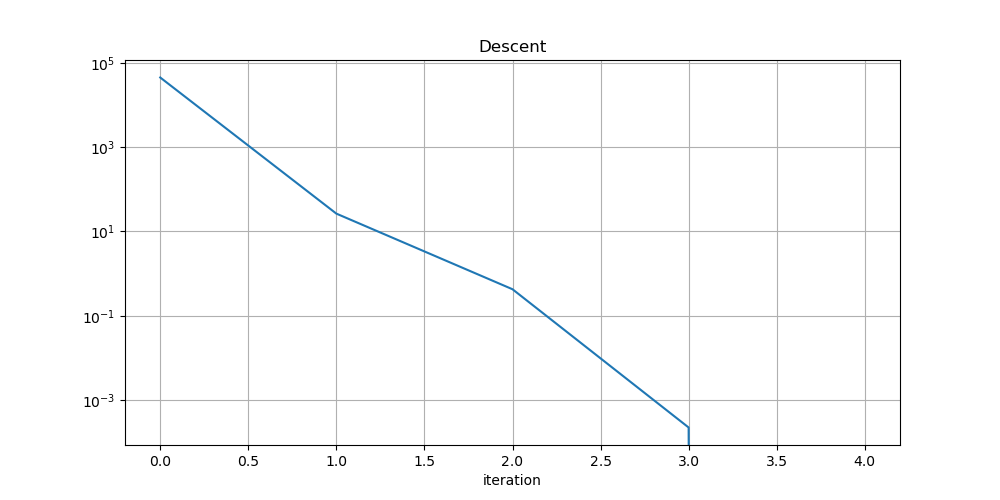

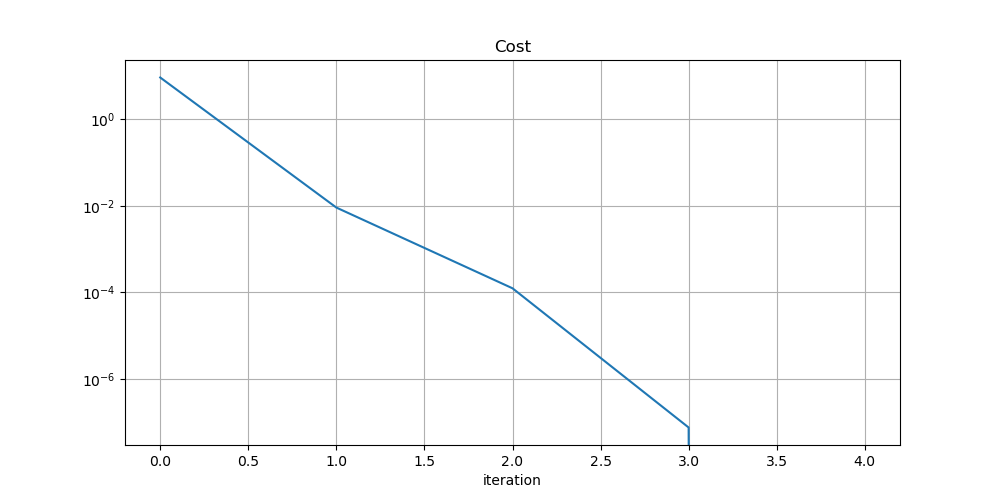

In [6]:
# Plotting the Graph Ball Position
#t = range(0,TT)
#fig0, ax0 = plt_.subplots(figsize=(10, 5))
#ax0.plot(t, xx_ref[0, :], '-', label='xx_ref_pos')
#ax0.plot(t, xx[0, :,Max_Iter], '--', label='xx_opt_0',lw = 3)
#ax0.legend(loc='lower left', ncol=1)
#plt_.title("Ball Position")
#plt_.xlabel("t")
#plt_.ylabel("p(t)")
#plt_.grid()
#plt_.show()
#plt_.close(fig0)

# Plotting the Graph Ball Velocity
#t = range(0,TT)
#fig1, ax1 = plt_.subplots(figsize=(10, 5))
#ax1.plot(t, xx_ref[1, :], '-', label='xx_ref_1')
#ax1.plot(t, xx[1, :,Max_Iter], '--', label='xx_opt_1',lw = 3)
#ax1.legend(loc='lower left', ncol=1)
#plt_.title("Ball Velocity")
#plt_.xlabel("t")
#plt_.ylabel("p_dot(t)")
#plt_.grid()
#plt_.show()
#plt_.close(fig1)

# Plotting the Graph Beam Position
#t = range(0,TT)
#fig2, ax2 = plt_.subplots(figsize=(10, 5))
#ax2.plot(t, xx_ref[2, :], '-', label='xx_ref_2')
#ax2.plot(t, xx[2, :,Max_Iter], '--', label='xx_opt_2',lw = 3)
#ax2.legend(loc='lower left', ncol=1)
#plt_.title("Beam Position")
#plt_.xlabel("t")
#plt_.ylabel("theta(t)")
#plt_.grid()
#plt_.show()
#plt_.close(fig2)

# Plotting the Graph
#t = range(0,TT)
#fig3, ax3 = plt_.subplots(figsize=(10, 5))
#ax3.plot(t, xx_ref[3, :], '-', label='xx_ref_3')
#ax3.plot(t, xx[3, :,Max_Iter], '--', label='xx_opt_3',lw = 3)
#ax3.legend(loc='lower left', ncol=1)
#plt_.title("Beam velocity")
#plt_.xlabel("t")
#plt_.ylabel("theta_dot(t)")
#plt_.grid()
#plt_.show()
#plt_.close(fig3)

# Plotting the Graph Input Torque
t = range(0,TT)
fig, ax = plt_.subplots(figsize=(10, 5))
ax.plot(t, uu_ref[0, :], '-', label='uu_ref')
ax.plot(t, uu[0, :,Max_Iter], '--', label='uu_opt',lw = 3)
ax.legend(loc='lower left', ncol=1)
plt_.title("Input Torque")
plt_.xlabel("t")
plt_.ylabel("torque(t)")
plt_.grid()
plt_.show()
plt_.close(fig)

#plotting the descent
iter = range(0,Max_Iter+1)
figd, axd = plt_.subplots(figsize=(10, 5))
#axd.plot(iter, np.abs(descent[0:Max_Iter+1,0]), '-', label='descent')
plt_.semilogy(iter, np.abs(descent[0:Max_Iter+1,0]))
plt_.title('Descent')
plt_.xlabel('iteration')
plt_.grid()
plt_.show()
plt_.close(figd)

#plotting the cost
iterc = range(0,Max_Iter)
JJ = np.abs(np.dot((cost[0:Max_Iter,0]-cost[Max_Iter,0]),cost[Max_Iter,0]**(-1)))
figc, axc = plt_.subplots(figsize=(10, 5))
axc.semilogy(iterc,np.abs(np.dot((cost[0:Max_Iter,0]-cost[Max_Iter,0]),cost[Max_Iter,0]**(-1))))
plt_.title('Cost')
plt_.xlabel('iteration')
plt_.grid()
plt_.show()
plt_.close(figc)

#save plot as images for report#
#fig0.savefig('plot/task_1_pos.jpg',transparent = True)
#fig1.savefig('plot/task_1_vel.jpg',transparent = True)
#fig2.savefig('plot/task_1_beam.jpg',transparent = True)
#fig3.savefig('plot/task_1_beamV.jpg',transparent = True)
fig.savefig(lfp+'/plot/task_1_2_torque.jpg',transparent = True)
figd.savefig(lfp+'/plot/descent_task_1-2.jpg',transparent = True)
figc.savefig(lfp+'/plot/cost_task_1_2.jpg',transparent = True)

**ANIMATION**

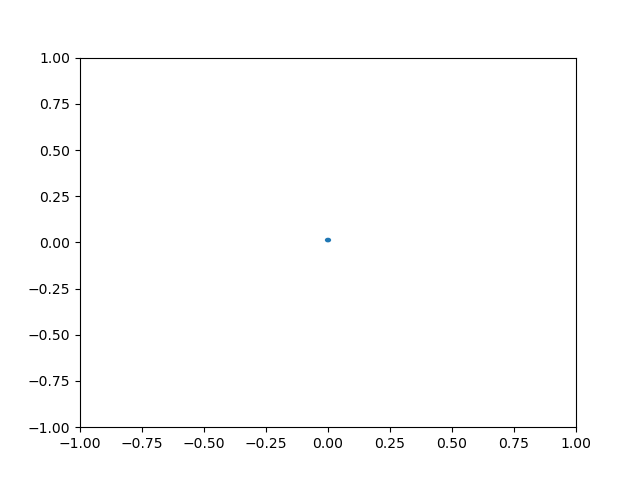

In [7]:
x_limit = params['LL']
y_limit = params['LL']
history_len = 5000;
ball_rad = params['rr']
beam_len = params['LL']
frame_rate = params['dt']
theta = xx[2, :, Max_Iter:Max_Iter + 1]
Xp = xx[0, :, Max_Iter:Max_Iter + 1]

anim = visu.animate(x_limit,
                    y_limit,
                    history_len,
                    ball_rad,
                    beam_len,
                    frame_rate,
                    theta,
                    Xp)

In [8]:
# SAVE ANIMATION AS GIF
anim.save(lfp+'/animations/Task_1_multistep.gif', writer='Pillow', fps = 40)

MovieWriter Pillow unavailable; using Pillow instead.
